In [107]:
import numpy as np
import seaborn as sns
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import timm
import math
import wandb
# from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback

import torch, torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torchvision.io import read_image

from sklearn import preprocessing

In [108]:
# Some pre-processing
# data_path = "/notebooks/Dataset/"
# df_ = pd.read_csv('/notebooks/Dataset/straight_cropped_chromosomes_dataset/data.csv')
# df_['file_path'] = data_path+df_['file_path']
df_ = pd.read_csv("/notebooks/Dataset/gband-data.csv")
# 763104351884.dkr.ecr.ap-south-1.amazonaws.com
# efficientnet-b4-gband-pt

In [109]:
df_.head()

,Unnamed: 0,file_path,pair_num,case_num
0,0,/notebooks/Dataset/KaryoTutor Images/karyotype_MDA_012/18_2.png,18,karyotype_MDA_012
1,1,/notebooks/Dataset/KaryoTutor Images/karyotype_MDA_012/21_3.png,21,karyotype_MDA_012
2,2,/notebooks/Dataset/KaryoTutor Images/karyotype_MDA_012/23_2.png,23,karyotype_MDA_012
3,3,/notebooks/Dataset/KaryoTutor Images/karyotype_MDA_012/4_1.png,4,karyotype_MDA_012
4,4,/notebooks/Dataset/KaryoTutor Images/karyotype_MDA_012/15_1.png,15,karyotype_MDA_012


## Get data into df

In [4]:
# df_ = pd.read_csv("/notebooks/Dataset/data.csv")

In [5]:
# df_.to_csv("/notebooks/Dataset/data.csv")

## Dataloader [Pytorch]

In [6]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df_, test_size=0.2, random_state=42, stratify=df_['pair_num'])

In [101]:
class KaryotypeDataset(torch.utils.data.Dataset):
    def __init__(self, df, is_valid=False, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform
        self.basic_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float),
            transforms.Resize((224,224)),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['file_path'].iloc[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.basic_transforms(image)
        label = self.df['pair_num'].iloc[idx]-1 # make it 0 -22
        label = torch.Tensor([label]).long().squeeze()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return TensorImage(image), label

In [102]:
transformations = transforms.Compose([
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomVerticalFlip(0.5),
                                      transforms.RandomRotation(0.3),
                                     ])

In [103]:
train_dataset = KaryotypeDataset(train_df, transform = transformations)
valid_dataset = KaryotypeDataset(valid_df)

In [104]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=8, pin_memory = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 32, shuffle = False, num_workers=8, pin_memory = True)

In [105]:
dls = DataLoaders(train_dataloader, valid_dataloader)

NameError: name 'DataLoaders' is not defined

In [106]:
for x,y in dls.train:
    print(x[0].shape)
    print((x[0][0][30][30]))
    print(max((x[0][0]).flatten()))
    plt.imshow(x[0].permute(1,2,0))
    break

NameError: name 'dls' is not defined

## Dataloader [fastai]

In [43]:
# def get_df(df):
#     return df
# def get_files(df):
#     return df['file_path']
# def get_label(df):
#     return df['pair_num']

In [44]:
# aug = [Rotate(0.3), Flip(0.3), Normalize()]

In [45]:
# def get_dls(df):
#     karyotype = DataBlock(
#         blocks=(ImageBlock, CategoryBlock),
#         get_items=get_df,
#         get_x=get_files,
#         get_y=get_label,
#         splitter=TrainTestSplitter(0.2, stratify=get_label(df), random_state=42),
#         item_tfms=Resize(224, method='squish'),
#         batch_tfms=aug,
#     )
#     dls = karyotype.dataloaders(df) 
#     return dls

In [46]:
# dls = get_dls(df_)

In [47]:
# temp = []
# for batch in dls.valid:
#     temp.extend(batch[1].cpu().numpy())

In [48]:
# sns.countplot(temp)

In [49]:
# means = [xb.mean(dim=(0, 2, 3)) for xb, yb in dls.train]
# stds = [xb.std(dim=(0, 2, 3)) for xb, yb in dls.train]
# mean, std = torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)
# print(mean, std)

In [50]:
# dls.show_batch()

In [51]:
for i,o in dls.train:
    print(i.shape,o.shape)
    print(o)
    # print(i)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])
tensor([ 7, 16, 20,  2, 15, 14,  5,  9, 10, 11,  2, 14, 22,  6,  4,  6,  2, 18,
        17,  0,  7, 14, 16,  5, 21,  1, 18, 12,  5,  6,  7, 18])


## Define ArcMargin & GeM module

In [110]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [111]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(),  device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

## Model

In [112]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

class ArcFaceModel(nn.Module):
    def __init__(self, model_name, pretrained=True, backbone=None):
        super().__init__()
        if backbone:
            self.model = timm.create_model(model_name, pretrained=pretrained, num_classes = 0,in_chans=3)
            self.model.load_state_dict(torch.load(backbone))
        else:
            self.model = timm.create_model(model_name, pretrained=pretrained, num_classes = 0,in_chans=3)
        # in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.embedding = nn.Sequential(
            nn.LazyLinear(1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(1024,512),
        )
        self.fc = ArcMarginProduct(512, 
                                   23,
                                   s=2, 
                                   m=1, 
                                   easy_margin=False, 
                                   ls_eps=0.0)

    def forward(self, images, labels):
        features = self.model(images)
        # pooled_features = self.model(images).flatten(1)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        output = self.fc(embedding, labels)
        return output
    
    def extract(self, images):
        features = self.model(images)
        # pooled_features = self.model(images).flatten(1)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        return embedding

In [113]:
model = ArcFaceModel('efficientnet_b4', backbone="/notebooks/Arcface Model/efb4_backbone.pth")

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [114]:
model.extract(torch.rand((2,3,224,224)))

tensor([[ 0.0300,  0.2386, -0.9903,  ...,  0.1638,  0.8432,  0.2233],
        [-0.6791,  0.1563, -0.2458,  ...,  0.7081,  0.3223,  0.0839]],
       grad_fn=<AddmmBackward0>)

## Set up Wandb

In [64]:
# import wandb
# wandb.login()

In [65]:
# CONFIG = {
#     'embedding_size' : 512,
#     'batch_size' : 32,
#     'base' : 'efficientnet_b4',
#     'image_size' : 224,
#     'loss_func' : 'ArcFace',
#     'dataset':'g_band',
#     'version': 1,
# }

In [66]:
# import time
# run_name = CONFIG['base'] + "-" + str(int(time.time()))

In [67]:
# # Initialize W&B run
# run = wandb.init(project='hsp-karyotype', 
#                  group='ArcFace Baseline',
#                  job_type='train',
#                  name = run_name, 
#                  config=CONFIG,
#                 )

## Learner [fastai]

In [68]:
class AmpCallback(Callback):
    def before_batch(self):
        self.learn.xb = (self.x, self.y)

In [69]:
learn = Learner(dls, 
                model, 
                metrics=accuracy,
                loss_func=CrossEntropyLossFlat(),
                cbs=[
                    AmpCallback,
                    SaveModelCallback(monitor='valid_loss', min_delta=0.01, fname='arcface_baseline_v9',),
                    # WandbCallback(log_model=True, seed=42),
                ]
               )

In [70]:
# torch.cuda.empty_cache()

## Model Training

SuggestedLRs(valley=0.0003311311302240938)

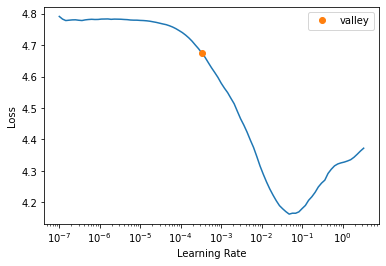

In [71]:
learn.lr_find()

In [72]:
epochs = 150
bl = 0.00033

In [ ]:
learn.fit_one_cycle(epochs, bl)

epoch,train_loss,valid_loss,accuracy,time
0,4.604438,4.410965,0.000000,00:18
1,4.395784,4.100037,0.000000,00:19
2,4.199598,3.814387,0.000000,00:19
3,4.019718,3.591601,0.000000,00:19
4,3.874921,3.425112,0.002155,00:19
5,3.747024,3.283719,0.021552,00:19
6,3.638765,3.163467,0.088362,00:19
7,3.521532,3.062663,0.230603,00:19
8,3.410235,2.956716,0.357759,00:19
9,3.320829,2.885185,0.441810,00:19


Better model found at epoch 0 with valid_loss value: 4.410965442657471.
Better model found at epoch 1 with valid_loss value: 4.100037097930908.
Better model found at epoch 2 with valid_loss value: 3.814387321472168.
Better model found at epoch 3 with valid_loss value: 3.5916011333465576.
Better model found at epoch 4 with valid_loss value: 3.42511248588562.
Better model found at epoch 5 with valid_loss value: 3.2837188243865967.
Better model found at epoch 6 with valid_loss value: 3.1634674072265625.
Better model found at epoch 7 with valid_loss value: 3.0626630783081055.
Better model found at epoch 8 with valid_loss value: 2.9567158222198486.
Better model found at epoch 9 with valid_loss value: 2.8851845264434814.
Better model found at epoch 10 with valid_loss value: 2.8195555210113525.
Better model found at epoch 11 with valid_loss value: 2.7675509452819824.
Better model found at epoch 12 with valid_loss value: 2.715178966522217.
Better model found at epoch 13 with valid_loss value: 

In [106]:
# interp = ClassificationInterpretation.from_learner(learn)

In [107]:
# interp.plot_confusion_matrix()

In [108]:
# interp.most_confused()[:5]

In [109]:
# res = learn.validate()

In [46]:
# torch.save(model, "arcface_ef_b4_150ep_v3")

In [47]:
# wandb.finish()

## Running inference on data

In [115]:
model.load_state_dict(torch.load("/notebooks/Arcface Model/models/arcface_baseline_v9.pth", map_location=torch.device('cuda')))
model=model.to(torch.device('cuda'))

In [389]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df_, test_size=0.2, random_state=84, stratify=df_['pair_num'])

In [390]:
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224,224)),
    transforms.Normalize(0,1)
])

def get_image(path):
    im = Image.open(path).convert('RGB')
    im = basic_transforms(im)
    return im.cuda()

In [391]:
import tqdm
@torch.inference_mode()
def get_embeddings(model,df):
    model.eval()
    
    LABELS = []
    EMBEDS = []
    IDS = []
    
    for i in tqdm.tqdm(range(len(df))):
        im = get_image(df['file_path'].iloc[i])
        im = im.unsqueeze(0)
        label = df['pair_num'].iloc[i]
        model.eval()
        output = model.extract(im)
        
        LABELS.append(label)
        EMBEDS.append(output.cpu().numpy())
    
    return EMBEDS, LABELS

In [393]:
emb, lab = get_embeddings(model, df_ )
emb_ = np.vstack(emb)
# ids = np.arange(4231)
# 2317

100%|██████████| 2317/2317 [01:07<00:00, 34.12it/s]


In [394]:
ids = np.arange(2317)

In [395]:
import faiss

In [396]:
index = faiss.IndexFlatIP(512)
index = faiss.IndexIDMap(index)
faiss.normalize_L2(emb_)
index.add_with_ids(emb_, ids)

In [397]:
mp = {}
for i in ids:
    mp[i] = lab[i]

In [398]:
# import pickle
# pickle.dump(index, open('index.pkl', 'wb'))
# pickle.dump(mp, open('map_index2pair.pkl', 'wb'))

In [399]:
from scipy.special import softmax
def get_pred(model, x, index):
    
    model.eval()
    q = model.extract(x)
    q = q.cpu().detach().numpy()
    # print(q.shape, q.dtype)
    faiss.normalize_L2(q)
    s, s_id = index.search(q,7)
    out = [0]*23
    c = [mp[i] for i in s_id[0]]
    l = 2300
    for i_, i in enumerate(c):
        out[i-1] += 1
        l-=1
    # output = np.array(out)
    # norm = np.linalg.norm(output)
    # output = output/norm
    # print(output)
    # print(softmax(output))
    # return l
    return np.asarray(softmax(out))

### Get ef model for ensemble

In [400]:
# class baseModel(nn.Module):
#     def __init__(self, model_name, pretrained=True):
#         super().__init__()
#         self.model_ft = timm.create_model(model_name, pretrained=pretrained, num_classes=0,in_chans=3)
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.LazyLinear(1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(p=0.3),
#             nn.Linear(1024,512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(p=0.3),
#             nn.Linear(512,256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(p=0.3),
#             nn.Linear(256,23),
#         )

#     def forward(self, x):
#         x_features = self.model_ft(x)
#         return self.classifier(x_features)

In [401]:
# model_ef = baseModel('efficientnet_b4', pretrained=False)
# saved_model = "/notebooks/Baseline Models/models/efficientnet_b4-1656650171.pth"
# model_ef.load_state_dict(torch.load(saved_model))
# model_ef = model.cuda()

In [402]:
import tqdm
acc = 0
conf_matrix = np.zeros((23,23))
y_true = []
y_pred = []
ims_ = []
for i in tqdm.tqdm(range (len(valid_df))):
    path = valid_df['file_path'].values[i]
    pn = valid_df['pair_num'].values[i]
    im = get_image(path)
    im = im.unsqueeze(0)
    out = get_pred(model, im, index)
    # print(out1, np.argmax(out1) +1)
    # print(out2, np.argmax(out2) +1)
    # print(out, np.argmax(out) +1)
    # print(pn)
    # print()
    y = np.argmax(out) +1
    # print(out)
    # if(y != pn):
    #     ims_.append((path, y, pn))
    #     break
    conf_matrix[pn-1][y-1]+=1
    y_true.append(pn)
    y_pred.append(y)
    if (pn==y):
        acc+=1
    # print(pn,y)
    # break
    # break

100%|██████████| 464/464 [00:18<00:00, 24.69it/s]


In [403]:
acc/len(valid_df)

0.9568965517241379

<AxesSubplot:>

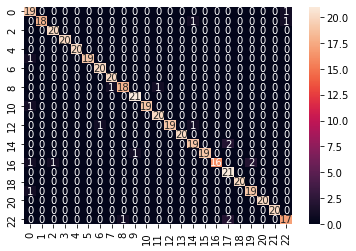

In [404]:
sns.heatmap(conf_matrix, annot=True)

In [218]:
t = df_.groupby(['pair_num']).count()

In [219]:
t

,Unnamed: 0,file_path,case_num
pair_num,,,
1,99,99,99
2,100,100,100
3,100,100,100
4,100,100,100
5,100,100,100
6,101,101,101
7,100,100,100
8,102,102,102
9,100,100,100


### For deployment

In [95]:
sample = torch.rand((3,3,224,224)).cuda()

In [96]:
out = model.extract(sample)

In [97]:
out = out.cpu().detach().numpy().tolist()

In [98]:
def get_pred_mod(x, index):
    x = np.asarray(x, dtype=np.float32)
    x = np.expand_dims(x,0)
    print(x.shape)
    print(x.dtype)
    faiss.normalize_L2(x)
    s, s_id = index.search(x,150)
    out = [0]*23
    c = [mp[i] for i in s_id[0]]
    for i in c:
        out[i-1]+=1
    return out

In [99]:
outs = []
for r in out:
    outs.append(get_pred_mod(r, index))

(1, 512)
float32
(1, 512)
float32
(1, 512)
float32


In [100]:
outs

[[68, 79, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 [68, 79, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 [68, 79, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]]

In [108]:
F

<module 'torch.nn.functional' from '/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py'>

In [4]:
F

<module 'torch.nn.functional' from '/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py'>

In [382]:
n = np.random.rand(224,224,3)
x = np.asarray(n, dtype=np.float32)

In [405]:
# from PIL import Image
# im = Image.fromarray(x)